In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

import sys
sys.path.append(os.path.join(os.environ['NHL_DATA_DIR']), '..')

In [4]:


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold

import src.visualization.visualize as VizManager
import src.data.NHLDataManager as DataManager
import src.features.build_features as FeaturesManager




In [5]:
seasons_year = [2015, 2016, 2017, 2018, 2019]
features_data_df = FeaturesManager.build_features(seasons_year, with_player_stats=True)
features_data_df.sample(10)

,Game ID,Event Index,Period,Team,Type,Shot Type,Shooter,Shooter ID,Goalie,Goalie ID,...,Is Goal,Is Empty,Period seconds,Game seconds,Last event angle,Rebound,Change in Shot Angle,Speed From Previous Event,Shooter Goal Ratio Last Season,Goalie Goal Ratio Last Season
125805,2016020856,225,2,Colorado Avalanche (COL),SHOT,Tip-In,John Mitchell,8470750,Cam Ward,8470320,...,0,0,1145,2345,-47.726311,False,0.000000,11.543396,0.099010,0.090841
129687,2016020919,174,2,New Jersey Devils (NJD),SHOT,Snap Shot,Ben Lovejoy,8473933,Al Montoya,8471219,...,0,0,634,1834,7.125016,False,0.000000,17.902514,0.044444,0.080592
318231,2019020204,193,2,Edmonton Oilers (EDM),SHOT,Wrist Shot,Patrick Russell,8479466,Matt Murray,8476899,...,0,0,754,1954,-34.992020,True,25.098100,5.843735,0.000000,0.080928
56371,2015020940,56,1,Toronto Maple Leafs (TOR),SHOT,Tip-In,Brad Boyes,8468504,Andrei Vasilevskiy,8476883,...,0,0,603,603,29.357754,False,0.000000,1.068000,0.092715,0.081928
9602,2015020162,181,3,St. Louis Blues (STL),SHOT,Tip-In,Kyle Brodziak,8470803,Devan Dubnyk,8471227,...,0,0,129,2529,7.926927,False,0.000000,11.010663,0.104651,0.070769
226043,2017021239,204,2,St. Louis Blues (STL),SHOT,Wrist Shot,Alex Pietrangelo,8474565,J-F Berube,8475234,...,0,0,1177,2377,-17.684392,False,0.000000,0.989139,0.077348,0.110701
278828,2018020831,82,1,St. Louis Blues (STL),SHOT,Wrist Shot,Alex Pietrangelo,8474565,Andrei Vasilevskiy,8476883,...,0,0,1103,1103,33.690068,False,0.000000,2.991033,0.069444,0.080482
103377,2016020487,330,5,Florida Panthers (FLA),GOAL,Snap Shot,Vincent Trocheck,8476389,Robin Lehner,8475215,...,1,1,0,3900,0.327401,True,9.977446,NaN,0.143678,NaN
308752,2019020048,21,1,Detroit Red Wings (DET),SHOT,Snap Shot,Patrik Nemeth,8475747,Carey Price,8471679,...,0,0,169,169,53.841815,True,14.634611,2.806698,0.017544,0.082480
163082,2017020228,300,3,Columbus Blue Jackets (CBJ),SHOT,Wrist Shot,Oliver Bjorkstrand,8477416,Pekka Rinne,8471469,...,0,0,1020,3420,47.726311,False,0.000000,2.302173,0.109091,0.081958


In [6]:
# features_data_df.query("`Game ID` == '2018020192' & Type == 'GOAL'")[['Game ID', 'Team', 'X', 'Y', 'st_X', 'st_Y', 'Period', 'Period seconds', 'Rebound']]
print(features_data_df['st_X'])
print(features_data_df.shape)

0         63.0
1        -73.0
2         67.0
3         52.0
4         55.0
          ... 
371900    77.0
371901    76.0
371902    79.0
371903    81.0
371904    67.0
Name: st_X, Length: 371905, dtype: object
(371905, 34)


In [8]:
data_manager = DataManager.NHLDataManager()
df = data_manager.get_goals_and_shots_df_standardised(2018, 'Regular', 192)
df.query("Type == 'GOAL'")[['Team', 'X', 'Y', 'st_X', 'st_Y']]

,Team,X,Y,st_X,st_Y
0,Winnipeg Jets (WPG),81.0,5.0,-81.0,-5.0
1,Florida Panthers (FLA),-76.0,2.0,-76.0,2.0
2,Winnipeg Jets (WPG),69.0,-24.0,-69.0,24.0
3,Florida Panthers (FLA),58.0,-21.0,-58.0,21.0
4,Florida Panthers (FLA),41.0,-6.0,-41.0,6.0
5,Florida Panthers (FLA),-58.0,2.0,-58.0,2.0


In [9]:
player_stats = data_manager.load_player(8473618, 2015)
shots = player_stats['stats'][0]['splits'][0]['stat']['shots']
goals = player_stats['stats'][0]['splits'][0]['stat']['goals']

print(shots, goals, goals/shots)

133 9 0.06766917293233082


In [10]:
features_data_df.query('`Shooter ID` == 8473618')['Shooter Goal Ratio Last Season'].unique()

array([0.13953488, 0.06766917, 0.09701493, 0.12230216])

In [11]:
names_all = list(features_data_df.columns) 


names = ['Period', 'Shot Type', 'st_X', 'st_Y', 'Shot distance', 'Shot angle', 'Is Empty', 'Rebound', 'Change in Shot Angle', 
         'Speed From Previous Event', 'Game seconds', 'Last event st_X', 'Last event st_Y', 'Last event elapsed time', 'Last event distance',
         'Shooter Goal Ratio Last Season', 'Goalie Goal Ratio Last Season',
         'Is Goal']

feature_names, target_name = names[0:-2], names[-1]
feature_names = np.array(feature_names)

df_filter = features_data_df[names]

print(feature_names)

# Be careful with dropna. For example, if we choose the 'Strenght' feature, if will remove all the shots
df_filter = df_filter.dropna()

df_filter[df_filter.isna().any(axis=1)]

['Period' 'Shot Type' 'st_X' 'st_Y' 'Shot distance' 'Shot angle'
 'Is Empty' 'Rebound' 'Change in Shot Angle' 'Speed From Previous Event'
 'Game seconds' 'Last event st_X' 'Last event st_Y'
 'Last event elapsed time' 'Last event distance'
 'Shooter Goal Ratio Last Season']


,Period,Shot Type,st_X,st_Y,Shot distance,Shot angle,Is Empty,Rebound,Change in Shot Angle,Speed From Previous Event,Game seconds,Last event st_X,Last event st_Y,Last event elapsed time,Last event distance,Shooter Goal Ratio Last Season,Goalie Goal Ratio Last Season,Is Goal


In [12]:
df_filter.describe()

,Period,st_X,st_Y,Shot distance,Shot angle,Is Empty,Change in Shot Angle,Speed From Previous Event,Game seconds,Last event st_X,Last event st_Y,Last event elapsed time,Last event distance,Shooter Goal Ratio Last Season,Goalie Goal Ratio Last Season,Is Goal
count,259018.000000,259018.000000,259018.000000,259018.000000,259018.000000,259018.0,259018.000000,259018.000000,259018.000000,259018.000000,259018.000000,259018.000000,259018.000000,259018.000000,259018.000000,259018.000000
mean,2.020203,56.055290,-0.148136,38.439954,-0.891925,0.0,7.220201,7.933230,1816.260152,23.031604,-0.097484,15.594661,61.733745,0.091540,0.085236,0.085577
std,0.839381,29.648173,19.091931,29.176366,36.523690,0.0,19.523583,10.037908,1046.428723,60.450682,23.064309,14.833595,46.002235,0.049410,0.012955,0.279739
min,1.000000,-99.000000,-42.000000,1.000000,-161.565051,0.0,0.000000,0.000000,3.000000,-99.000000,-42.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,44.000000,-14.000000,17.804494,-28.610460,0.0,0.000000,2.101000,919.000000,-35.000000,-22.000000,5.000000,26.172505,0.058480,0.077922,0.000000
50%,2.000000,62.000000,0.000000,34.132096,0.000000,0.0,0.000000,4.670799,1802.000000,49.000000,0.000000,11.000000,46.615448,0.091667,0.083135,0.000000
75%,3.000000,76.000000,14.000000,50.447993,27.095552,0.0,0.000000,10.000000,2704.000000,69.000000,22.000000,21.000000,92.005435,0.124464,0.090601,0.000000
max,4.000000,99.000000,42.000000,189.654950,180.000000,0.0,209.528672,186.625293,3900.000000,99.000000,42.000000,194.000000,200.000000,1.000000,0.333333,1.000000


In [13]:
dummy_shot_type = pd.get_dummies(df_filter['Shot Type'], prefix='Shot Type')
df_filter = df_filter.merge(dummy_shot_type, left_index=True, right_index=True)
df_filter = df_filter.drop(columns=['Shot Type'])

# Update features_name
feature_names = list(df_filter.columns)
feature_names = [f for f in feature_names if f != 'Is Goal']
feature_names = np.array(feature_names)
print(feature_names)


df_filter.sample(10)

['Period' 'st_X' 'st_Y' 'Shot distance' 'Shot angle' 'Is Empty' 'Rebound'
 'Change in Shot Angle' 'Speed From Previous Event' 'Game seconds'
 'Last event st_X' 'Last event st_Y' 'Last event elapsed time'
 'Last event distance' 'Shooter Goal Ratio Last Season'
 'Goalie Goal Ratio Last Season' 'Shot Type_Backhand'
 'Shot Type_Deflected' 'Shot Type_Slap Shot' 'Shot Type_Snap Shot'
 'Shot Type_Tip-In' 'Shot Type_Wrap-around' 'Shot Type_Wrist Shot']


,Period,st_X,st_Y,Shot distance,Shot angle,Is Empty,Rebound,Change in Shot Angle,Speed From Previous Event,Game seconds,...,Shooter Goal Ratio Last Season,Goalie Goal Ratio Last Season,Is Goal,Shot Type_Backhand,Shot Type_Deflected,Shot Type_Slap Shot,Shot Type_Snap Shot,Shot Type_Tip-In,Shot Type_Wrap-around,Shot Type_Wrist Shot
89958,3,82.0,-20.0,21.189620,-70.709954,0,False,0.000000,3.807887,3139,...,0.125786,0.077922,0,0,1,0,0,0,0,0
227245,3,62.0,-2.0,27.073973,-4.236395,0,False,0.000000,16.269415,2436,...,0.143369,0.076923,0,0,0,1,0,0,0,0
87223,1,61.0,21.0,35.000000,36.869898,0,False,0.000000,12.547687,643,...,0.050459,0.081991,0,0,0,0,1,0,0,0
190702,4,85.0,5.0,6.403124,51.340192,0,False,0.000000,11.556648,3709,...,0.114754,0.085093,0,0,0,0,0,0,0,1
139640,3,73.0,23.0,28.017851,55.175511,0,False,0.000000,2.524259,2787,...,0.110497,0.080592,0,0,0,0,1,0,0,0
47109,2,81.0,-14.0,16.124515,-60.255119,0,False,0.000000,12.971122,2126,...,0.089606,0.076810,0,0,0,0,0,0,0,1
41448,1,36.0,6.0,53.338541,6.458816,0,False,0.000000,8.655634,507,...,0.063830,0.074672,0,0,0,1,0,0,0,0
101258,1,50.0,-21.0,44.294469,-28.300756,0,False,0.000000,14.700718,709,...,0.109375,0.094703,0,1,0,0,0,0,0,0
71138,3,-86.0,6.0,175.102827,1.963658,0,True,0.054505,55.036352,3320,...,0.170330,0.077502,0,0,0,0,0,0,0,1
205355,2,52.0,-18.0,41.146081,-25.942295,0,True,12.425190,3.804237,1285,...,0.077670,0.080775,0,0,0,0,0,0,0,1


In [14]:
df_train, df_valid = train_test_split(df_filter, test_size=0.2, random_state=42)

In [15]:
X_train = df_train[feature_names].to_numpy()
y_train = df_train[target_name].to_numpy()

X_valid = df_valid[feature_names].to_numpy()
y_valid = df_valid[target_name].to_numpy()

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)




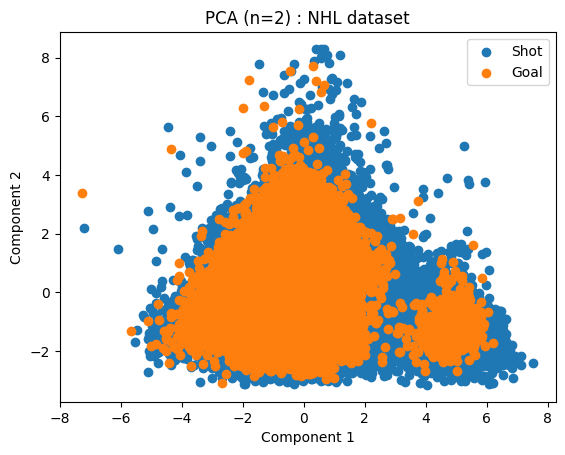

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_r = pca.fit(X_train_scaled).transform(X_train_scaled)

target_names = ['Shot', 'Goal']

for i, target_name in enumerate(target_names):
    plt.scatter(X_r[y_train == i, 0], X_r[y_train == i, 1], label=target_name)

plt.legend(loc='best', scatterpoints=1)

plt.title('PCA (n=2) : NHL dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.plot();

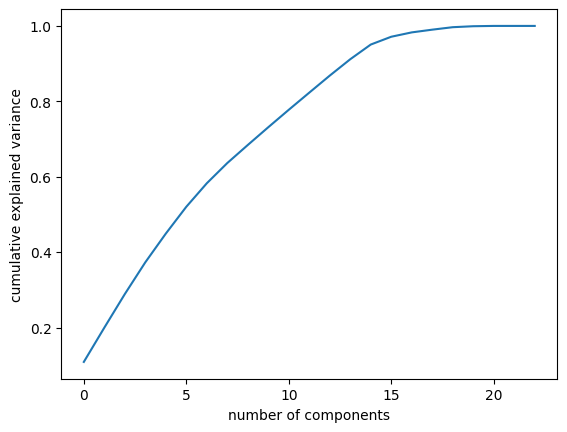

In [17]:
pca = PCA().fit(X_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [18]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

# Lasso SVC
lsvc = LinearSVC(C=0.001, penalty="l1", dual=False).fit(X_train_scaled, y_train)

# Select features based on Lasso
model = SelectFromModel(lsvc)

model.fit(X_train_scaled,y_train)

print('Selected Support : ', model.get_support())

print('Selected Features: ', feature_names[model.get_support()])
print('Rejected Features: ', feature_names[~model.get_support()])

# features = model.transform(X_train)
# print('Selected Features shape: ', features.shape)

Selected Support :  [ True  True False  True False False  True  True  True  True False False
  True  True  True False  True  True False  True  True  True  True]
Selected Features:  ['Period' 'st_X' 'Shot distance' 'Rebound' 'Change in Shot Angle'
 'Speed From Previous Event' 'Game seconds' 'Last event elapsed time'
 'Last event distance' 'Shooter Goal Ratio Last Season'
 'Shot Type_Backhand' 'Shot Type_Deflected' 'Shot Type_Snap Shot'
 'Shot Type_Tip-In' 'Shot Type_Wrap-around' 'Shot Type_Wrist Shot']
Rejected Features:  ['st_Y' 'Shot angle' 'Is Empty' 'Last event st_X' 'Last event st_Y'
 'Goalie Goal Ratio Last Season' 'Shot Type_Slap Shot']


In [19]:
# p (1-p) - Only for Boolean features
# Remove all features that are either one or zero (on or off) in more than (100*p)% of the samples
p = 0.9
selector = VarianceThreshold(threshold=(p * (1 - p)))
features = selector.fit_transform(X_train)

print('Selected Features: ', feature_names[selector.get_support()])
print('Rejected Features: ', feature_names[~selector.get_support()])

Selected Features:  ['Period' 'st_X' 'st_Y' 'Shot distance' 'Shot angle' 'Rebound'
 'Change in Shot Angle' 'Speed From Previous Event' 'Game seconds'
 'Last event st_X' 'Last event st_Y' 'Last event elapsed time'
 'Last event distance' 'Shot Type_Slap Shot' 'Shot Type_Snap Shot'
 'Shot Type_Wrist Shot']
Rejected Features:  ['Is Empty' 'Shooter Goal Ratio Last Season'
 'Goalie Goal Ratio Last Season' 'Shot Type_Backhand'
 'Shot Type_Deflected' 'Shot Type_Tip-In' 'Shot Type_Wrap-around']


In [20]:
# Feature Selection with chi-square

# Features should be non negative. 
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(X_train)
X_train_minmax = min_max_scaler.transform(X_train)
X_valid_minmax = min_max_scaler.transform(X_valid)

# Selection
num_features = 12
selector = SelectKBest(score_func=chi2, k=num_features)
fit = selector.fit(X_train_minmax, y_train)

features = fit.transform(X_train_minmax)

scores = fit.scores_.argsort()[::-1]
print('Selected Features: ', feature_names[scores][:num_features])
print('Rejected Features: ', feature_names[scores][num_features:])

Selected Features:  ['Is Empty' 'Shot Type_Tip-In' 'Shot distance' 'Shot Type_Deflected'
 'Rebound' 'Shot Type_Slap Shot' 'st_X' 'Change in Shot Angle'
 'Shot Type_Wrist Shot' 'Shot Type_Backhand' 'Last event elapsed time'
 'Last event st_X']
Rejected Features:  ['Last event distance' 'Speed From Previous Event'
 'Shooter Goal Ratio Last Season' 'Shot Type_Wrap-around'
 'Shot Type_Snap Shot' 'Period' 'Game seconds' 'Last event st_Y' 'st_Y'
 'Shot angle' 'Goalie Goal Ratio Last Season']


In [21]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier('penalty=l1')
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_minmax, y_train)

print(rf_random.best_params_)

: 

: 

In [38]:
from sklearn.ensemble import RandomForestClassifier
clf_forest =  RandomForestClassifier(random_state=0).fit(X_train_minmax, y_train)

In [39]:
from sklearn.ensemble import AdaBoostClassifier
clf_adb =  AdaBoostClassifier(random_state=0).fit(X_train_minmax, y_train)

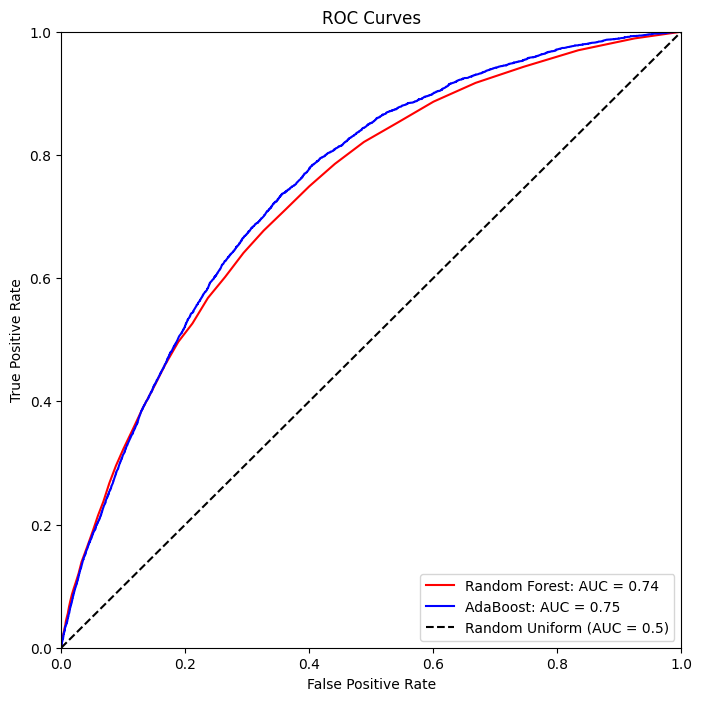

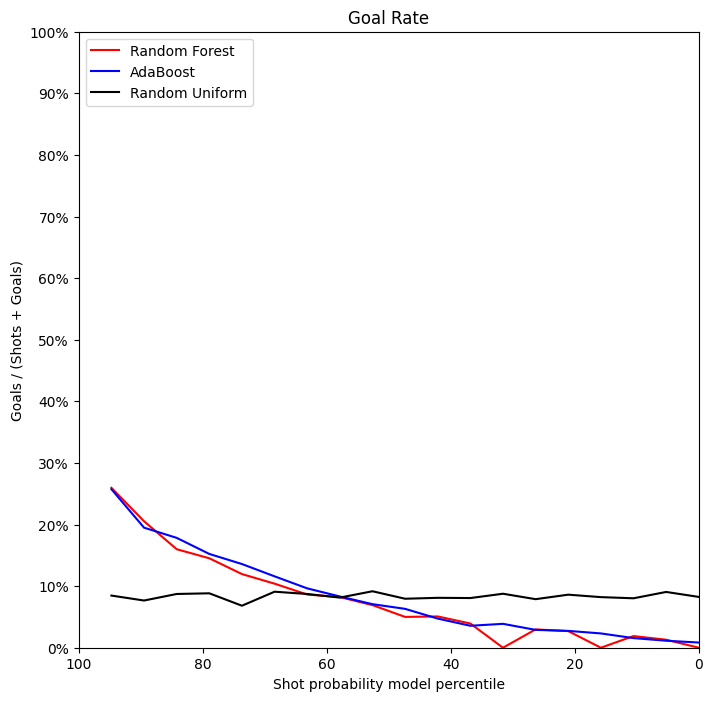

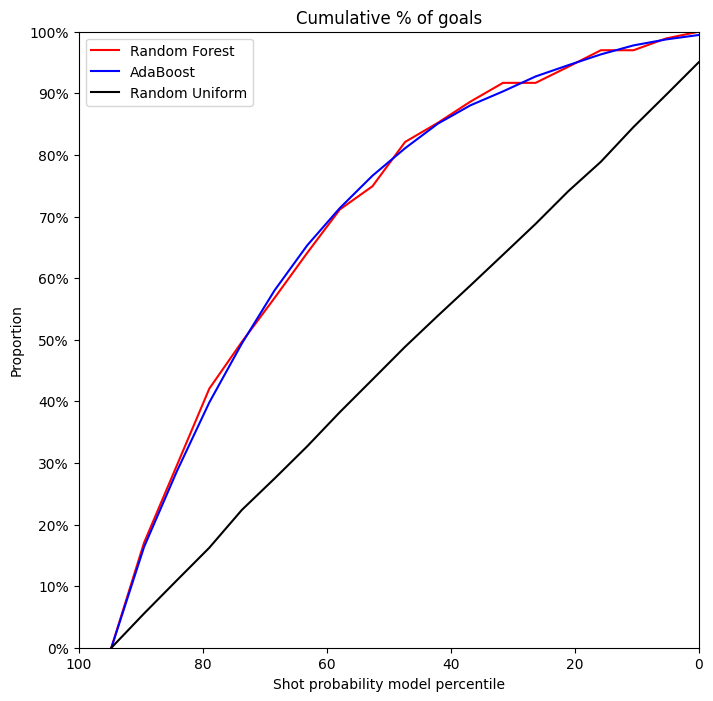

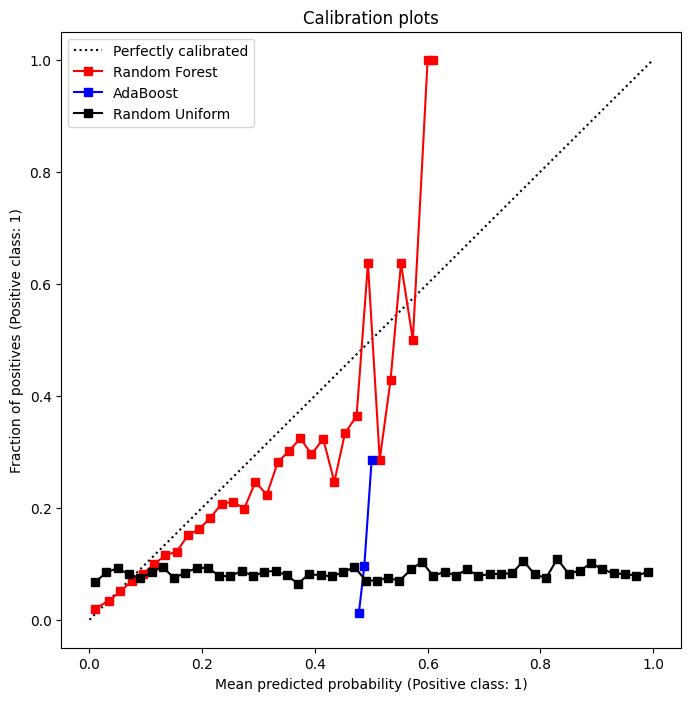

In [37]:
classifiers = [(clf_forest, 'Random Forest', X_valid_minmax, y_valid), 
               (clf_adb, 'AdaBoost', X_valid_minmax, y_valid)]

VizManager.plot_all_figures(classifiers, add_random=True)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay

clf_names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

classifiers_plot = []

for clf, clf_name in zip(classifiers, clf_names):
    print(clf_name)
    clf.fit(X_train_minmax, y_train)
    classifiers_plot.append( (clf, clf_name, X_valid_minmax, y_valid) )
    

Nearest Neighbors
Linear SVM
RBF SVM


In [ ]:
VizManager.plot_all_figures(classifiers_plot, add_random=True)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

tuned_parameters = [
  {'kernel': ['rbf'],
  'gamma': np.logspace(-3, -4, num=50),
  'C': np.logspace(0, 3, num=50)},
  
  {'kernel': ['linear'],
   'C': np.logspace(0, 3, num=50)},
]

metric = 'f1_macro'
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True)

grid_search = RandomizedSearchCV(
    SVC(), tuned_parameters, n_iter=16, scoring=metric, cv=cv_strategy, 
)
grid_search.fit(X_train_minmax, y_train);

print()
print(grid_search.best_params_)
print(grid_search.best_score_)

print()
y_true, y_pred = y_valid, grid_search.predict(X_valid_minmax)
print(classification_report(y_true, y_pred))
print()

In [27]:
import time

start_time = time.time()
importances = clf_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

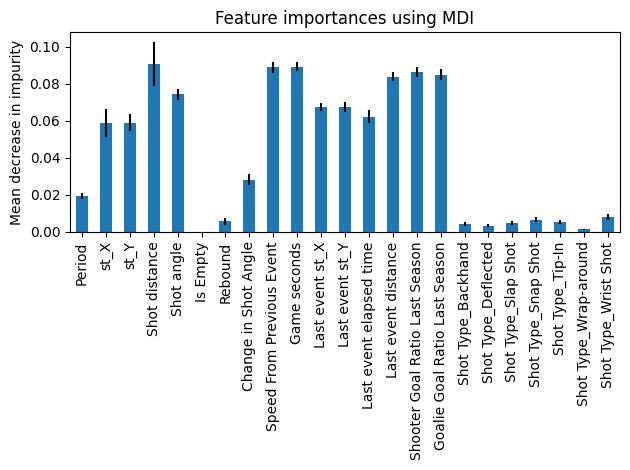

In [28]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI") # Mean Decrease in impurity
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [56]:
# from sklearn.inspection import permutation_importance

# start_time = time.time()
# result = permutation_importance(
#     clf_forest, X_valid_minmax, y_valid, n_repeats=5, random_state=42, n_jobs=2
# )
# elapsed_time = time.time() - start_time
# print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

# forest_importances = pd.Series(result.importances_mean, index=feature_names)

: 

: 

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(clf_forest, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=data.feature_names[perm_sorted_idx],
)
fig.tight_layout()
plt.show()